# Part 1: Create the FrozenLake.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# global variables
BOARD_ROWS = 5 # 5x5 grid size
BOARD_COLS = 5 # 5x5 grid size
GOAL = (4, 4) # goal state
START = (0, 0) # start state
HOLES = [(1,0), (1,3), (3,1), (4,2)] # four holes

In [22]:
class State:
    def __init__(self, state=START):        
        self.state = state
        self.isEnd = False        

    def getReward(self):
        if self.state == GOAL: # The reward for reaching the goal state is +10.0
            return 10    
        elif self.state in HOLES: # The reward for falling into a hole is -5.0
            return -5
        else: # the reward for each transition to a non-terminal state is -1.0
            return -1

    def isEndFunc(self): # The episode ends if the agent falls into a hole or reaches the goal state.
        if (self.state == GOAL) or (self.state in HOLES):
            self.isEnd = True

    def nxtPosition(self, action):      
        if action == 0: # up            
            nxtState = (self.state[0] - 1, self.state[1])                
        elif action == 1: # down
            nxtState = (self.state[0] + 1, self.state[1])
        elif action == 2: # left
            nxtState = (self.state[0], self.state[1] - 1)
        else:
            nxtState = (self.state[0], self.state[1] + 1)
            
        if (nxtState[0] >= 0) and (nxtState[0] <= (BOARD_ROWS - 1)):
            if (nxtState[1] >= 0) and (nxtState[1] <= (BOARD_COLS - 1)):                    
                    return nxtState # if next state legal
        
        return self.state # Any move off the grid leaves state unchanged


# Part 2: Implement the Reinforcement Learning algorithm Q-learning

In [58]:
class Agent:
    
    def __init__(self, alpha, gamma, eps, eps_decay=False):
        self.states = [] 
        self.actions = [0, 1, 2, 3] # up, down, left, right
        self.State = State()
        self.alpha = alpha  # determines convergence rate of the algorithm 
        self.gamma = gamma # discount factor determines importance of future rewards
        self.eps = eps # explore/ exploit ratio 
        self.eps_decay = eps_decay
        
        # initialise state values
        self.action_values = {}
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                for k in range(len(self.actions)):
                    self.action_values[(i, j, k)] = 0 # set initial value to 0 for Q(s,a)
        self.new_action_values = {}
        
    def chooseAction(self):
        # based on policy eps-greedy
        mx_nxt_value = 0
        action = 0        
       
        if np.random.uniform(0, 1) <= self.eps:
            action = np.random.choice(self.actions)
            
        else:
            # greedy action
            for a in self.actions:
                nxt_state = self.State.nxtPosition(a)
                nxt_value = self.action_values[(nxt_state[0], nxt_state[1], a)]
                if nxt_value >= mx_nxt_value:
                    action = a
                    mx_nxt_value = nxt_value
                    
        return action
    
    def takeAction(self, action):
        position = self.State.nxtPosition(action)
        self.State.state = position
        
    def QMax(self, action):
        mx_nxt_state_value = 0
        
        if self.State.state == GOAL:
            mx_nxt_state_value = 0
        else:
            for a in self.actions:
                # nxt_state = self.State.nxtPosition(a)
                nxt_state = self.State.state
                nxt_state_value = self.action_values[(nxt_state[0], nxt_state[1], a)]
                if nxt_state_value >= mx_nxt_state_value:
                    mx_nxt_state_value = nxt_state_value
        
        return mx_nxt_state_value
    
    def epsilon_linear_decay(self, episodes): # Linear Decay
        delta_eps = (self.eps - 0.0) / episodes
        self.eps -= delta_eps
        
    def epsilon_exp_decay(self):
        self.eps *= 0.9
    
    def q_learning(self, episodes):
        x = 0
        
        self.cum_rewards = np.empty(episodes)
        
        
        # loop through all the states
        while x < episodes:
            # init S
            self.State.isEnd = False
            self.State.state = START # re init S Start state   
                        
            while True: # repeat for each step of the episode until S is terminal
                # choose action A from S
                action = self.chooseAction()
                
                # store current state for Q updates
                currentState = (self.State.state[0], self.State.state[1], action)
                
                # take action A and go to next state
                self.takeAction(action)
                
                # reward R of next state
                reward = self.State.getReward()
                self.cum_rewards[x] = reward
                
                # mark the end state if it is GOAL or HOLE
                self.State.isEndFunc()
                
                # update state actio values
                self.action_values[currentState] = self.action_values[currentState] + \
                                                    self.alpha * (reward + self.gamma * \
                                                                 self.QMax(action) - \
                                                                 self.action_values[currentState])
                
                # check if S is terminal
                if self.State.isEnd:
                    state = (self.State.state[0], self.State.state[1], np.random.choice(self.actions))
                    self.action_values[state] = reward
                    break
                    
            x += 1
            
            if self.eps_decay == True:
                self.epsilon_linear_decay(episodes)
            
        self.cumulative_average = np.cumsum(self.cum_rewards) / (np.arange(episodes) + 1)
            
            
    def showValues(self):
        for i in range(0, BOARD_ROWS):
            print('---------------------------------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                mx_nxt_value = -5
                for a in self.actions:
                    nxt_value = self.action_values[(i, j, a)]
                    if nxt_value >= mx_nxt_value:
                        mx_nxt_value = nxt_value
                        
                out += str(round(mx_nxt_value, 3)).ljust(6) + ' | '
            print(out)
        print('----------------------------------------')

In [59]:
def plot_learninf_curve(cum_reward_average):
    
    # plot moving average ctr
    plt.plot(cum_reward_average)
    plt.xscale('log')
    plt.show()

# Experiments for each hyperparameter combination

## Basic hyperparameters: Alpha = 0.5, Gamma = 0.9, and Epsilon = 0.10

In [61]:
ag_basic = Agent(alpha=0.5, gamma=0.9, eps=0.10)
ag_basic.q_learning(10000)
print(ag_basic.showValues())

with open("max_action_value_estimates_basic_hyperparam.txt", "w") as f:
    print(ag_basic.action_values, file=f)

---------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
---------------------------------------
| -5     | 1.81   | 3.122  | -5     | 6.2    | 
---------------------------------------
| 1.81   | 3.122  | 4.58   | 6.2    | 8.0    | 
---------------------------------------
| 0      | -5     | 6.2    | 8.0    | 10.0   | 
---------------------------------------
| 0      | 0      | -5     | 10.0   | 10     | 
----------------------------------------
None


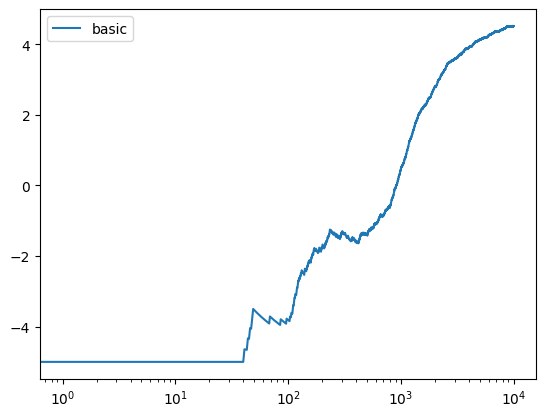

In [67]:
plt.plot(ag_basic.cumulative_average, label='basic')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

## Epsilon decay: Alpha = 0.5, Gamma = 0.9, and Epsilon in range (0.10, 0.0).

In [63]:
ag_decay = Agent(alpha=0.5, gamma=0.9, eps=0.10, eps_decay=True)
ag_decay.q_learning(10000)
print(ag_decay.showValues())

with open("max_action_value_estimates_epsilon_decay.txt", "w") as f:
    print(ag_decay.action_values, file=f)

---------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
---------------------------------------
| -5     | 0.0    | 1.329  | -5     | 6.2    | 
---------------------------------------
| 0      | 2.026  | 4.474  | 6.2    | 8.0    | 
---------------------------------------
| 0      | 0      | 5.781  | 8.0    | 10.0   | 
---------------------------------------
| 0      | 0      | 0      | 7.5    | 10     | 
----------------------------------------
None


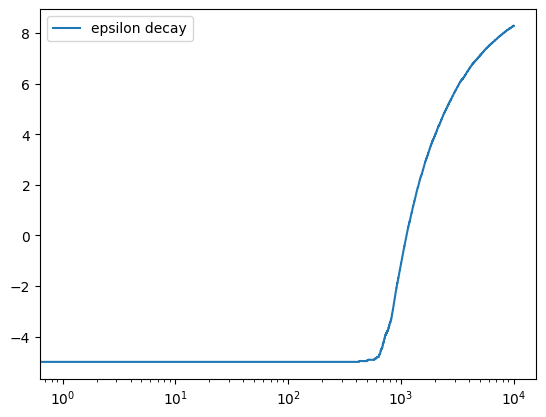

In [68]:
plt.plot(ag_decay.cumulative_average, label='epsilon decay')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

## Your own choice

In [101]:
myag = Agent(alpha=0.5, gamma=0.9, eps=0.09, eps_decay=True)
myag.q_learning(10000)
print(myag.showValues())

with open("max_action_value_estimates_myag.txt", "w") as f:
    print(myag.action_values, file=f)

---------------------------------------
| -0.434 | 0.629  | 1.81   | 3.122  | 4.58   | 
---------------------------------------
| -5     | -0.434 | 1.458  | -5     | 6.2    | 
---------------------------------------
| 0      | 1.343  | 4.257  | 6.2    | 8.0    | 
---------------------------------------
| 0      | 0      | 5.106  | 8.0    | 10.0   | 
---------------------------------------
| 0      | 0      | 0      | 5.0    | 10     | 
----------------------------------------
None


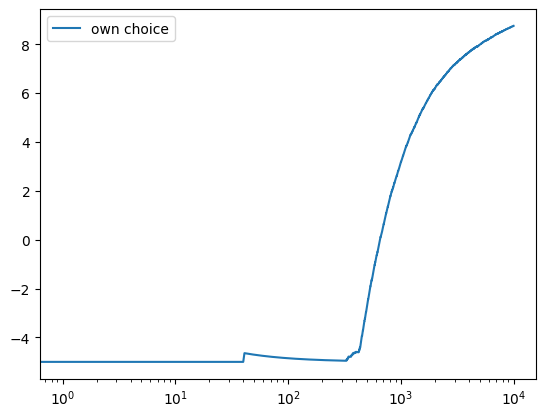

In [102]:
plt.plot(myag.cumulative_average, label='own choice')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

## Plot the the average of cumulative rewards of three experiments of different hyperparameter combination

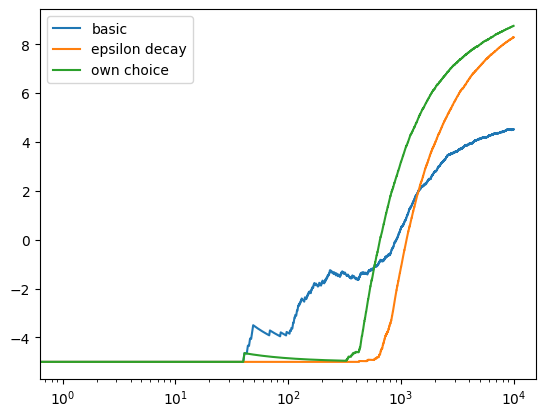

In [103]:
plt.plot(ag_basic.cumulative_average, label='basic')
plt.plot(ag_decay.cumulative_average, label='epsilon decay')
plt.plot(myag.cumulative_average, label='own choice')
plt.xscale('log')
plt.legend(loc='best')
plt.show()